## Project milestone 2, CS-401 : Applied data analysis, group : TheAvengers


This Notebook can be divided in two parts. First, we handled our initial CMU dataset by enriching with other movies datasets and preprocess it (section 1 and 2 below). Then, we started with a first analysis which include section 3 to 5.

<a id="0"></a> 
 # Table of Contents  
1. [Import libraries and python files](#1)     
1. [Load the CMU dataset and additional datasets](#2)    
   2.1. [Load IMDB rating and movie from Kaggle datasets](#3)      
   2.2 [Load movie from Kaggle datasets](#4)        
   2.3 [Load Oscars movie dataset](#19)       
   2.4 [Filter the renowned actor](#20) 
3. [Let's start the analysis](#5)    
   3.1. [Pie chart of the countries, genres and langues categories](#6)    
   3.2. [Histogram of Revenues](#7)    
   3.3. [Evolution of revenues per year](#8)     
   3.4. [Histogram of Average Rating](#9)     
   3.5. [Evolution of the mean Average Rating per year](#10)     
   3.6. [Scatter plot of the average Rating and Revenue](#11)     
   3.7. [Pearson correlation](#12)     
   3.8. [Box plot of the number of known actor versus the log revenues](#13)       
   3.9. [Linear Regression - log revenue on number of known actors](#14)       
   3.10. [Box plot of the rating per number of known actors](#15)        
   3.11. [Linear regression - Rating on number of actors](#16)      
4. [Interaction matrix](#17)
5. [Network Analysis](#18)



<a id="1"></a> 
## 1. Import libraries and python files

In [3]:
import pandas as pd
import numpy as np
import json
import sys
import requests
import re
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
from sklearn.cluster import KMeans

# Ignore all warnings
warnings.filterwarnings('ignore')

from data_loader import *
%load_ext autoreload
%autoreload 2

<a id="2"></a> 
## 2. Load the CMU dataset and additional datasets

Lets first download our datasets and  extract the former countriers, the genres and the languages from each movie and create new columns feature that will be able to access more easily on the mentionned datas.

In [4]:
#loading the datasets
dataFrame_movie = load_cmu_movies()
dataFrame_character = load_cmu_characters()
#dataFrame_kaggle_movie = load_kaggle_movies()

#extracting the aforementioned features
dataFrame_movie['Country_List'] = dataFrame_movie['Countries'].apply(extract_features_names)
dataFrame_movie['Genre_List'] = dataFrame_movie['Genres'].apply(extract_features_names)
dataFrame_movie['Language_List'] = dataFrame_movie['Language'].apply(extract_features_names)

We decided to add additional datasets in order to complete our datas. However, trying to merge those datasets based on their Movies names doesn't work as there are movies that have the same Name but are in fact different. Therefore, it is complicated to differentiate movies based on their names. To overcome this issue, we identified each movie by its Freebase ID or its IMDB ID (depending on the dataset). To do so, we first need to retreive the IMDB ID (i.e. tconst column) based on the movie's Freebase ID.

In [5]:
#df_id_translation = get_wikidata_id_translations()
#display(df_id_translation)

#save the dataframe to a JSON file
#df_id_translation.to_json('id-translation.wikidata.json', orient='records', lines=True)

#replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

#load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

#display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm3628633,/m/0k83_1r
1,nm0012078,/m/02q173g
2,nm0394250,/m/03kfdk
3,tt0324924,/m/0ct2z8
4,nm0119354,/m/0356cy
...,...,...
990453,tt29521500,None
990454,nm2106941,None
990455,nm2186144,None
990456,nm4531538,None


Then, we can drop Nan and duplicates values and merge it with the CMU movies dataset 

In [6]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

dataFrame_movie = pd.merge(dataFrame_movie, df_id_translation, on='Freebase ID', how='left')

print(dataFrame_movie.shape)

(81740, 16)


In [7]:
#compute percentage of missing values for df_mvoei
percentage_missing_values_year = (dataFrame_movie['Year'].isna().sum()/len(dataFrame_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (dataFrame_movie['Month'].isna().sum()/len(dataFrame_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

#percentage_missing_values_runtime = (dataFrame_movie['Runtime'].isna().sum()/len(dataFrame_movie['Runtime']))*100
#print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (dataFrame_movie['tconst'].isna().sum()/len(dataFrame_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")

The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.833%.
The percentage of missing values 'Box office' is 89.724%.
The percentage of missing values 'tconst' is 9.769%.


<a id="3"></a> 
### 2.1. Load IMDB rating and movie from Kaggle datasets

In [8]:
#load imdb dataset (from kaggle)
dataFrame_imdb_movie = load_movie_imdb_kaggle()
dataFrame_imdb_rating = load_rating_imdb_kaggle() 

In [9]:
#merge movies with rating 
df_movie_rating = pd.merge(dataFrame_imdb_movie, dataFrame_imdb_rating, on='tconst', how='inner')

In [10]:
#merge CMU dataset with IMDB dataset
dataFrame_movie = pd.merge(dataFrame_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
print(dataFrame_movie.shape)

(81740, 18)


<a id="4"></a> 
### 2.2. Load movie from Kaggle datasets

In [11]:
#load kaggle movies dataset
dataFrame_kaggle_movie = load_kaggle_movies()

In [12]:
#merging the two datasets
dataFrame_movie = dataFrame_movie.merge(dataFrame_kaggle_movie[['Name', 'tconst', 'Revenue', 'budget']], on=['Name', 'tconst'], how='left', suffixes=('', '_df2'))

#use 'combine_first' to fill in the 'Revenue' values from df_kaggle_movie where they are NaN in df_movie
dataFrame_movie['Revenue'] = dataFrame_movie['Revenue'].combine_first(dataFrame_movie['Revenue_df2'])

#drop the 'Revenue_df2' column
dataFrame_movie.drop('Revenue_df2', axis=1, inplace=True)

#drop duplicates
dataFrame_movie = dataFrame_movie.drop_duplicates(subset='Wikipedia ID', keep='first')
print(dataFrame_movie.shape)

(81740, 19)


In [13]:
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_movie['averageRating'].isna().sum()/len(dataFrame_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_revenues = (dataFrame_movie['budget'].isna().sum()/len(dataFrame_movie['budget']))*100
print(f"The percentage of zero values 'budget' is {format(percentage_missing_values_revenues, '.3f')}%.")

The percentage of missing values 'Revenue' is 70.124%.
The percentage of missing values 'averageRating' is 40.105%.
The percentage of zero values 'budget' is 92.663%.


Right now, we need to adjust the Budget and the Revenue based on the CPI (Consumer Price index):

In [14]:
#load inflation dataset

inflation_US = load_inflation()

In [15]:
dataFrame_movie

,Wikipedia ID,Freebase ID,Name,Release date,Revenue,Run Time,Language,Countries,Genres,Year,Month,Day,Country_List,Genre_List,Language_List,tconst,averageRating,numVotes,budget
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],tt0245916,NaN,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,[Norway],"[Crime Fiction, Drama]",[Norwegian Language],tt0094806,5.6,40.0,NaN
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[English Language],tt0094320,6.1,2888.0,NaN
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,[Germany],[Drama],[German Language],tt0083949,6.0,621.0,NaN
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,5,29,[United States of America],"[Short Film, Silent film, Indie, Comedy]","[Silent film, English Language]",tt0002894,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,[United States of America],[Drama],[English Language],tt1816585,NaN,NaN,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,0.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",[English Language],tt1606259,NaN,NaN,NaN
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,[United States of America],"[Satire, Comedy]",[English Language],tt0362411,5.8,110.0,NaN
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",[Japanese Language],tt0113726,NaN,NaN,NaN


In [16]:
median = dataFrame_movie['Year'].median()
dataFrame_movie['Year'] = dataFrame_movie['Year'].fillna(median)

#remove movie before 1960  which is the first year we have data for inflation
dataFrame_movie = dataFrame_movie[dataFrame_movie['Year'] > 1913]

#merge inflation dataset with movie dataset
dataFrame_movie = dataFrame_movie.merge(inflation_US, on='Year', how='left')

#compute the inflation adjusted revenue and budget
dataFrame_movie['adjusted_revenue'] = dataFrame_movie['Revenue'] * 100/dataFrame_movie['CPI']
dataFrame_movie['adjusted_budget'] = dataFrame_movie['budget'] * 100/dataFrame_movie['CPI']

In [17]:
print(dataFrame_movie.shape)

(80796, 23)


In [18]:
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_movie['averageRating'].isna().sum()/len(dataFrame_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_revenues = (dataFrame_movie['budget'].isna().sum()/len(dataFrame_movie['budget']))*100
print(f"The percentage of zero values 'budget' is {format(percentage_missing_values_revenues, '.3f')}%.")

The percentage of missing values 'Revenue' is 69.851%.
The percentage of missing values 'averageRating' is 39.491%.
The percentage of zero values 'budget' is 92.581%.


<a id="19"></a> 
### 2.3. Load Oscars movie dataset

Now, we want to select only actors that can be qualified as "renowned" and then list the number of "renowned" actors per movie. 

In [19]:
#load oscat dataset
dataFrame_oscar = load_oscar_winner()

In [20]:
#merge dataFrame_character with dataFrame_oscar to know if the character won an oscar
dataFrame_actor = pd.merge(dataFrame_character, dataFrame_oscar[['Actor Name', 'Win', 'Nomination']], on='Actor Name', how='left')
print(dataFrame_actor.shape)

(450668, 15)


In [21]:
#merge dataFrame_character_filtered with dataFrame_movie to get the Revenue, Average Rating, and Number of Votes for each actor
dataFrame_actor = pd.merge(dataFrame_actor, dataFrame_movie[['Freebase ID', 'adjusted_revenue', 'averageRating', 'numVotes']], on='Freebase ID', how='left')
print(dataFrame_actor.shape)

(450668, 18)


In [22]:
percentage_missing_values_revenues = (dataFrame_actor['adjusted_revenue'].isna().sum()/len(dataFrame_actor['adjusted_revenue']))*100
print(f"The percentage of missing values 'adjusted_revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_actor['averageRating'].isna().sum()/len(dataFrame_actor['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_winner = (dataFrame_actor['Win'].isna().sum()/len(dataFrame_actor['Win']))*100
print(f"The percentage of missing values 'Win' is {format(percentage_missing_values_winner, '.3f')}%.")

percentage_missing_values_winner = (dataFrame_actor['Nomination'].isna().sum()/len(dataFrame_actor['Nomination']))*100
print(f"The percentage of missing values 'Nomination' is {format(percentage_missing_values_winner, '.3f')}%.")

The percentage of missing values 'adjusted_revenue' is 49.800%.
The percentage of missing values 'averageRating' is 27.703%.
The percentage of missing values 'Win' is 92.709%.
The percentage of missing values 'Nomination' is 92.709%.


Now, for the purpose of the analyze, if an actor has played multiple roles on the same movie, we want to keep only one instance. As we are only interested of the number of movies played by an actor 

In [ ]:
#make a copy of dataFrame_actor
dataFrame_actor_filtered = dataFrame_actor.copy()

#if an actor has played multiple character for a same movie (same Freebase ID), we keep only the first instance
dataFrame_actor_filtered = dataFrame_actor_filtered.drop_duplicates(subset=['Freebase ID', 'Freebase Actor ID'], keep='first')

print(dataFrame_actor_filtered.shape)

In [23]:
# Group by 'Actor ID' and aggregate
actor_grouped = dataFrame_actor_filtered.groupby('Freebase Actor ID').agg(
    actor_name=('Actor Name', 'first'),                    #get the actor name
    number_of_movies=('Freebase Actor ID', 'size'),        #count the number of movies per actor
    average_revenue=('adjusted_revenue', 'mean'),          #compute the mean revenue
    average_rating=('averageRating', 'mean'),              #compute the mean rating
    oscar_win=('Win', 'first'),                            #take first value from the winner column
    oscar_nomination=('Nomination', 'first'),              #take the first value from the nomination column
).reset_index()

In [24]:
display(actor_grouped)

,Freebase Actor ID,actor_name,number_of_movies,average_revenue,average_rating,oscar_win,oscar_nomination
0,/m/010p3,Adam Carolla,12,1.899452e+07,5.166667,NaN,NaN
1,/m/010q36,Fred Rogers,1,4.120323e+08,6.100000,NaN,NaN
2,/m/010wx,Aria Giovanni,1,NaN,NaN,NaN,NaN
3,/m/010xjr,Richard Harris,54,1.100966e+08,6.370000,0.0,2.0
4,/m/0112yl,Toshiro Mifune,48,1.464278e+07,7.189362,NaN,NaN
...,...,...,...,...,...,...,...
135755,/m/0z58,Ardal O'Hanlon,1,NaN,NaN,NaN,NaN
135756,/m/0z9q0,"José Luis Rodríguez ""El Puma""",1,2.889396e+06,NaN,NaN,NaN
135757,/m/0zcb7,Marcus Giamatti,6,8.661802e+06,6.260000,NaN,NaN
135758,/m/0zcbl,Paul Giamatti,54,9.239275e+07,6.484615,0.0,1.0


<a id="20"></a> 
### 2.4. Filter the renowned actors

Right now, based on the above features, we want to only keep "renowned" actors. To do so, we will first use a K-Means algorithm to split actor in different clusters. 

In [25]:
#let's do some first preprocessing steps by removing some row with very low features values

#fill NaN values with 0 for oscar_win and oscar_nomination
actor_grouped['oscar_win'] = actor_grouped['oscar_win'].fillna(0)
actor_grouped['oscar_nomination'] = actor_grouped['oscar_nomination'].fillna(0)


#remove actors with Nan values for average_revenue or average_rating
actor_grouped = actor_grouped[~actor_grouped['average_revenue'].isna()]
actor_grouped = actor_grouped[~actor_grouped['average_rating'].isna()]

#remove actors with 0 values for average_revenue or average_rating
actor_grouped = actor_grouped[actor_grouped['average_revenue'] != 0]
actor_grouped = actor_grouped[actor_grouped['average_rating'] != 0]

#remove actors with only 1 movie or Nan Movies
actor_grouped = actor_grouped[~actor_grouped['number_of_movies'].isna()]
actor_grouped = actor_grouped[actor_grouped['number_of_movies'] > 10] # To reduce the number of actor

print(actor_grouped.shape)

(6902, 7)


In [26]:
#create a copty of the dataframe
actor_grouped_copy = actor_grouped.copy(deep=True)

In [27]:
display(actor_grouped_copy)

,Freebase Actor ID,actor_name,number_of_movies,average_revenue,average_rating,oscar_win,oscar_nomination
0,/m/010p3,Adam Carolla,12,1.899452e+07,5.166667,0.0,0.0
3,/m/010xjr,Richard Harris,54,1.100966e+08,6.370000,0.0,2.0
4,/m/0112yl,Toshiro Mifune,48,1.464278e+07,7.189362,0.0,0.0
8,/m/011_3s,Lily Tomlin,34,5.490873e+07,6.374194,0.0,1.0
11,/m/011_nf,Warner Baxter,36,7.966328e+06,6.180000,1.0,0.0
...,...,...,...,...,...,...,...
135747,/m/0y58x,Devon Sawa,19,4.707858e+07,6.061538,0.0,0.0
135751,/m/0ywqc,Donald Sutherland,112,6.598966e+07,6.287629,0.0,0.0
135753,/m/0z05l,Graham Greene,27,1.472560e+08,6.390000,0.0,1.0
135754,/m/0z4s,Anthony Hopkins,83,1.107221e+08,6.553846,2.0,4.0


START FROM HERE 

# Interaction Matrix
Now, the idea is to create a matrix. Each row of the matrix represent a differente movie. Every Column represents a different actor. The matrix returns 1 if the actor i plays in the movie j and 0 otherwise

count    63692.000000
mean         6.972791
std          5.334468
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max        115.000000
Name: Actor Name, dtype: float64


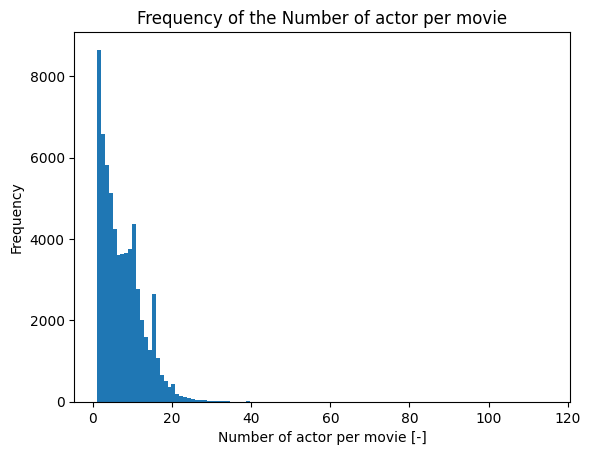

In [28]:

df_count = dataFrame_movie.merge(dataFrame_character, on = 'Wikipedia ID', how = 'left') # POPULATE EACH MOVIE WITH ACTOR 
counter = df_count.groupby('Wikipedia ID')['Actor Name'].nunique() # We count the number of actor per movie
# remove the movies that doesn't have any actor
counter = counter[counter>0]
print(counter.describe())
plt.hist(counter, bins =max(counter))

plt.title('Frequency of the Number of actor per movie')
plt.xlabel('Number of actor per movie [-]')
plt.ylabel('Frequency')

plt.show()

In [27]:



df_test = df_count[['Name','Actor Name']]
df_test['Value'] = 1
display(df_test)

# Chunk size for processing
chunk_size = 10000  # Adjust based on available memory

# Split df_count into chunks
chunks = [df_count[i:i + chunk_size] for i in range(0, len(df_count), chunk_size)]

# Initialize an empty binary matrix
binary_matrix = pd.DataFrame()

# Process the DataFrame chunks
for chunk in chunks:
    # Add a column of 1s for indicating actor presence
    chunk['Value'] = 1

    # Pivot the chunk to create a temporary binary matrix
    temp_binary_matrix = pd.pivot_table(chunk, values='Value', index='Name', columns='Actor Name', fill_value=0)

    # Concatenate the temporary binary matrix with the main binary matrix
    binary_matrix = pd.concat([binary_matrix, temp_binary_matrix], axis=0, sort=False)

# Reset the index of the final binary matrix
binary_matrix.reset_index(inplace=True)# Get unique actors and movies
#actors =df_count['Actor Name'].unique()
#movies = df_count['Name'].unique()

# Create a binary matrix
#binary_matrix = pd.DataFrame(0, index=movies, columns=actors)

# Populate the binary matrix
#for movie, actor_list in zip(df_count['Name'], df_count['Actor Name']):
#   binary_matrix.loc[movie, actor_list] = 1

,Name,Actor Name,Value
0,Getting Away with Murder: The JonBenét Ramsey ...,Allen Cutler,1
1,Getting Away with Murder: The JonBenét Ramsey ...,Alice Barrett,1
2,Getting Away with Murder: The JonBenét Ramsey ...,Rod Britt,1
3,Getting Away with Murder: The JonBenét Ramsey ...,Hildy Brooks,1
4,Getting Away with Murder: The JonBenét Ramsey ...,Robert Catrini,1
...,...,...,...
466069,Spliced,Billy Morton,1
466070,Spliced,Andrea Runge,1
466071,Spliced,Wendy Anderson,1
466072,Spliced,Ariel Bastian,1


: 

: 

In [36]:
df_count.columns


Index(['Wikipedia ID', 'Freebase ID_x', 'Name', 'Release date_x', 'Revenue',
       'Run Time', 'Language', 'Countries', 'Genres', 'Year', 'Month', 'Day',
       'Country_List', 'Genre_List', 'Language_List', 'tconst',
       'averageRating', 'numVotes', 'budget', 'S1983', 'CPI',
       'adjusted_revenue', 'adjusted_budget', 'Freebase ID_y',
       'Release date_y', 'Character Name', 'Actor Birth', 'Actor Gender',
       'Actor Height', 'Ethnicity', 'Actor Name', 'Actor Age At Movie Release',
       'Freebase Actor/Character Map ID', 'Freebase Character ID',
       'Freebase Actor ID'],
      dtype='object')

In [30]:
tempo_df = df_count[['Name','Actor Name', 'Wikipedia ID']].groupby('Actor Name')[['Name','Wikipedia ID']].agg(list)


In [31]:
tempo_df = tempo_df.reset_index()
tempo_df.columns = ['Actor Name', 'Name','Wikipedia ID']
display(tempo_df)

,Actor Name,Name,Wikipedia ID
0,Cesarine Prinz\t,"[Artistenrevue, Mottige Janus]","[22643470, 22643388]"
1,Daniel Newman,[Riddler's Moon],[20116200]
2,'Big' Lee,[Badge 373],[23010798]
3,'Chicken' Holleman,[Boxcar Bertha],[1873017]
4,'Crazy George' Henderson,[The Milpitas Monster],[10050502]
...,...,...,...
133649,雅-miyavi-,[Oresama],[18728484]
133650,雪乃五月,[InuYasha the Movie: Affections Touching Acros...,"[5148040, 2583808]"
133651,高山久子,"[Wanna-Be's, Sakura Wars: The Movie, Naruto th...","[18771696, 9411697, 1706423]"
133652,高橋美紀,[Wanna-Be's],[18771696]


In [61]:
final_df = actor_grouped_copy.merge(tempo_df, how='left', left_on='actor_name', right_on='Actor Name')
final_df = final_df.dropna(subset = 'Wikipedia ID')

In [62]:
final_df['Wikipedia ID'].iloc[j]

[2002258,
 1380313,
 4228739,
 28327405,
 6675831,
 10646793,
 12423448,
 3528982,
 17735988,
 3799386,
 1939585,
 8960083,
 652255]

In [63]:
from itertools import product
from collections import Counter


# Create a list of unique names
unique_names = final_df['Actor Name'].unique()

# Create a square matrix to store the count of common names
matrix_size = len(unique_names)
common_names_matrix = np.zeros((matrix_size,matrix_size))

# Populate the matrix with the count of common names
for i in range(matrix_size-1):
    for j in range(matrix_size-1):
        common_names_matrix[i][j] = len(set((final_df['Wikipedia ID'].iloc[i])).intersection(set((final_df['Wikipedia ID'].iloc[j]))))


# Convert the matrix to a DataFrame for better visualization
binary_matrix = pd.DataFrame(common_names_matrix, index=unique_names, columns=unique_names)
 
print(binary_matrix)
display(tempo_df)

                   Adam Carolla  Richard Harris  Toshiro Mifune  Lily Tomlin  \
Adam Carolla               11.0             0.0             0.0          0.0   
Richard Harris              0.0            52.0             0.0          0.0   
Toshiro Mifune              0.0             0.0            48.0          0.0   
Lily Tomlin                 0.0             0.0             0.0         27.0   
Warner Baxter               0.0             0.0             0.0          0.0   
...                         ...             ...             ...          ...   
Devon Sawa                  0.0             0.0             0.0          0.0   
Donald Sutherland           0.0             0.0             0.0          0.0   
Graham Greene               0.0             0.0             0.0          0.0   
Anthony Hopkins             0.0             0.0             0.0          0.0   
Paul Giamatti               0.0             0.0             0.0          0.0   

                   Warner Baxter  Chest

,Actor Name,Name,Wikipedia ID
0,Cesarine Prinz\t,"[Artistenrevue, Mottige Janus]","[22643470, 22643388]"
1,Daniel Newman,[Riddler's Moon],[20116200]
2,'Big' Lee,[Badge 373],[23010798]
3,'Chicken' Holleman,[Boxcar Bertha],[1873017]
4,'Crazy George' Henderson,[The Milpitas Monster],[10050502]
...,...,...,...
133649,雅-miyavi-,[Oresama],[18728484]
133650,雪乃五月,[InuYasha the Movie: Affections Touching Acros...,"[5148040, 2583808]"
133651,高山久子,"[Wanna-Be's, Sakura Wars: The Movie, Naruto th...","[18771696, 9411697, 1706423]"
133652,高橋美紀,[Wanna-Be's],[18771696]


In [64]:
binary_matrix

,Adam Carolla,Richard Harris,Toshiro Mifune,Lily Tomlin,Warner Baxter,Chester Morris,Lewis Stone,Jack Webb,"Lon Chaney, Jr.",Lucy Liu,...,Tress MacNeille,José Ferrer,Sean Penn,Arnold Schwarzenegger,Amitabh Bachchan,Devon Sawa,Donald Sutherland,Graham Greene,Anthony Hopkins,Paul Giamatti
Adam Carolla,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Richard Harris,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Toshiro Mifune,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lily Tomlin,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Warner Baxter,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Devon Sawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0
Donald Sutherland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0
Graham Greene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,0.0,0.0
Anthony Hopkins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0


In [67]:
pure_interaction = binary_matrix - binary_matrix*np.eye(matrix_size)

pure_interaction = pure_interaction.sum(axis=1)

display(pure_interaction.sort_values())

Paul Giamatti          0.0
Martti Suosalo         0.0
Jerry Hardin           0.0
Colin Friels           0.0
Vesa-Matti Loiri       1.0
                     ...  
Vinessa Shaw         773.0
Graham Greene        796.0
Anupam Kher          852.0
Charlie Yeung        854.0
Frank Welker        1100.0
Length: 6898, dtype: float64

In [72]:
final_df[final_df['Actor Name'] == 'Frank Welker']

,Freebase Actor ID,actor_name,number_of_movies,average_revenue,average_rating,oscar_win,oscar_nomination,Actor Name,Name,Wikipedia ID
1549,/m/02gf_l,Frank Welker,183,1.123916e+08,6.316667,0.0,0.0,Frank Welker,[The Land Before Time III: The Time of the Gre...,"[2524925, 3477618, 2374400, 17864265, 2969042,..."


In [166]:
actor_interaction ={}
for i in range(matrix_size-1):
    u=0
    for j in range(matrix_size-1):
        if i != j :
            u += common_names_matrix[i][j]
    actor_interaction[unique_names[i]] = [u]

actor_interaction = dict(sorted(actor_interaction.items(), key=lambda item: item[1],reverse = True))


IndexError: list index out of range

In [ ]:
actor_interaction = dict(sorted(actor_interaction.items(), key=lambda item: item[1],reverse = True))

actor_interaction

{'Charlie Murphy': [1154.0],
 'Sadha': [1120.0],
 'Bijou Phillips': [972.0],
 'Vincent Schiavelli': [964.0],
 'Brendan Sexton III': [925.0],
 'Sid Caesar': [918.0],
 'Jesse White': [869.0],
 'Tovah Feldshuh': [868.0],
 'Alan Badel': [831.0],
 'Olivia Thirlby': [829.0],
 'Jackie Coogan': [825.0],
 'Kevin Nealon': [818.0],
 'Albert Dupontel': [817.0],
 'Thurl Ravenscroft': [779.0],
 'Norman Alden': [779.0],
 'Michel Simon': [777.0],
 'Ralf Harolde': [768.0],
 'Dwight Yoakam': [766.0],
 'Jon Favreau': [761.0],
 'Ciarán McMenamin': [759.0],
 'Anthony Edwards': [757.0],
 'Meredith Baxter': [752.0],
 'William Bendix': [739.0],
 'Tom McCamus': [727.0],
 'Aaron Kwok': [723.0],
 'Lee Bowman': [705.0],
 'James Marsden': [701.0],
 'Percy Kilbride': [696.0],
 'Richmond Arquette': [696.0],
 'Cassandra Peterson': [692.0],
 'Julie Andrews': [685.0],
 'Nigel Terry': [679.0],
 'Robert Romanus': [662.0],
 'Boyd Banks': [661.0],
 'Dylan Walsh': [657.0],
 'John Miljan': [654.0],
 'Tamsin Egerton': [653.0]

Let's take only actors that have played at leat 15 movies. 

Even with this filter, we still have a high number of actor (113). This is still a high number and if we want to test every pair of actor as a independant variable, we need (113*112)/2 beta. We still have the possibility to filter more using maybe more qualitative aspect. 

For each column of the filtered_binary_matrix, we multiply by every other column and them sum the new column

We have our matrix of interaction. We will sort a list of actor that interract the most with his pear. We set the diagonal of the matrix equal to 0 and count the number of interaction of each actor

In [116]:
display(binary_matrix.sum(axis=1).sort_values())

Paul Giamatti            0.0
David Zayas             11.0
Katheryn Winnick        11.0
Serge Reggiani          13.0
Eric Bogosian           13.0
                       ...  
Albert Dupontel       1139.0
Bijou Phillips        1145.0
Vincent Schiavelli    1153.0
Sadha                 1268.0
Charlie Murphy        1304.0
Length: 6899, dtype: float64

In [79]:
test = 0
for j in range(matrix_size-1):
    if j!=1549:
        test += len(set(final_df['Name'].iloc[j])&set(final_df['Name'].iloc[1549]))
print(test)

1155


In [158]:
display(actor_grouped_filtered)

NameError: name 'actor_grouped_filtered' is not defined

As we have define our list of "renowned" actor, we can now filtered the "dataFrame_character" according to it :

In [ ]:
#merge the actor_grouped_filtered with dataFrame_character to keep only the actors that are in the actor_grouped_filtered
dataFrame_character_filtered = pd.merge(dataFrame_character, actor_grouped_filtered[['Freebase Actor ID']], on='Freebase Actor ID', how='inner')
print(dataFrame_character_filtered.shape)

(13190, 13)


In [ ]:
#group dataFrame_character by Freebase ID and list the characters 
dataFrame_list_known_actors = dataFrame_character_filtered.groupby('Freebase ID')['Actor Name'].apply(list).reset_index()

dataFrame_list_known_actors.columns = ['Freebase ID', 'List of known actors']

display(dataFrame_list_known_actors)

,Freebase ID,List of known actors
0,/m/011xg5,"[Robin Williams, Meryl Streep, Ben Kingsley, W..."
1,/m/011xrr,[Jamie Lee Curtis]
2,/m/011ycb,"[Mira Sorvino, Paul Scofield]"
3,/m/011yd2,"[Tom Hanks, Emily Ann Lloyd]"
4,/m/011yg9,"[Emma Thompson, Kate Winslet]"
...,...,...
8979,/m/0yyn5,"[Kevin Spacey, Olympia Dukakis]"
8980,/m/0yyts,"[Morgan Freeman, Jessica Tandy]"
8981,/m/0yzbg,"[Robin Williams, Allelon Ruggiero, James Water..."
8982,/m/0yzp8,[Burt Lancaster]


In [ ]:
#now lets merge this new dataframe with the DataFrame_movie
dataFrame_movie = dataFrame_movie.merge(dataFrame_list_known_actors, on='Freebase ID', how='left')

#create a new column that count the number of known actors per movie based on the list of actors
dataFrame_movie['Number of known actors'] = dataFrame_movie['List of known actors'].apply(count_known_actors)

print(dataFrame_movie.shape)

(53425, 24)


Finally, we can take a look on the percentage of movies for which the list of actors is not available and then extract that will be useful for the analysis :

In [ ]:
#lets first make a copy of the dataset 
test = dataFrame_movie.copy()

#we define a function on the data_loader file that allows us to check if a list is empty or not
test['Non-Empty actors'] = test['List of known actors'].apply(is_nonempty_list)

#compute the percentage of movies with empty or NaN actors lists
percentage_with_nonempty_actors = (test[test['Non-Empty actors']].shape[0] / test.shape[0]) * 100


print(f"The percentage of missing values 'List of known actors' is {format(100 - percentage_with_nonempty_actors, '.3f')}%.")

The percentage of missing values 'List of known actors' is 87.850%.


In [ ]:
display(dataFrame_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Revenue,Run Time,Language,Countries,Genres,Year,...,Language_List,tconst,averageRating,numVotes,budget,CPI,adjusted_revenue,adjusted_budget,List of known actors,Number of known actors
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,...,[English Language],tt0245916,NaN,NaN,NaN,78.970721,NaN,NaN,NaN,0
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,[Norwegian Language],tt0094806,5.6,40.0,NaN,54.233135,NaN,NaN,NaN,0
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,...,[English Language],tt0094320,6.1,2888.0,NaN,52.108294,NaN,NaN,NaN,0
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,[German Language],tt0083949,6.0,621.0,NaN,45.676445,NaN,NaN,NaN,0
4,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,...,[English Language],NaN,NaN,NaN,NaN,82.490467,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,...,[English Language],tt1816585,NaN,NaN,NaN,103.156842,NaN,NaN,NaN,0
53421,34980460,/m/0g4pl34,Knuckle,2011-01-21,0.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,...,[English Language],tt1606259,6.8,3191.0,NaN,103.156842,0.0,NaN,NaN,0
53422,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,...,[English Language],tt0362411,5.8,110.0,NaN,19.177075,NaN,NaN,NaN,0
53423,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,...,[Japanese Language],tt0113726,NaN,NaN,NaN,64.349061,NaN,NaN,NaN,0


In [ ]:
percentage_missing_values_revenues = (dataFrame_movie['adjusted_revenue'].isna().sum()/len(dataFrame_movie['adjusted_revenue']))*100
print(f"The percentage of missing values 'adjusted_revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_movie['averageRating'].isna().sum()/len(dataFrame_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_budget = (dataFrame_movie['adjusted_budget'].isna().sum()/len(dataFrame_movie['adjusted_budget']))*100
print(f"The percentage of missing values 'adjusted_budget' is {format(percentage_missing_values_budget, '.3f')}%.")


The percentage of missing values 'adjusted_revenue' is 63.938%.
The percentage of missing values 'averageRating' is 25.696%.
The percentage of missing values 'adjusted_budget' is 89.569%.


<a id="5"></a> 
## 3. Let's start with the analysis

Let's start by removing Nan values from the revenues as well as revenues less equal or equal to 1 :

In [ ]:
dataFrame_movie = dataFrame_movie.dropna(subset=['Revenue'])
dataFrame_movie = dataFrame_movie[dataFrame_movie['Revenue'] >= 1]

#sanity check lets compute the percentage of missing values for the revenues 
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

The percentage of missing values 'Revenue' is 0.000%.


### Consumer Price Index
Let's take into account the fact that one dollar yesterday worth more than one dollar today.

In [ ]:
inflation_US = load_inflation()

Decision : if the year is not mentionned : replace the void by the median of the year

In [ ]:
median = dataFrame_movie['Year'].median()
dataFrame_movie['Year'] = dataFrame_movie['Year'].fillna(median)

# Remove outliers 
dataFrame_movie = dataFrame_movie[dataFrame_movie['Year'] > 1913]

# Useful to check if everything went right after 
print(len(dataFrame_movie['Revenue']))

#We perform the change in revenues
inflation_US = inflation_US.merge(dataFrame_movie, on = 'Year', how= 'right')
inflation_US['adj Revenue'] = inflation_US['Revenue'] * 100/inflation_US['CPI']


dataFrame_movie = pd.concat([dataFrame_movie.reset_index(drop=True), inflation_US[['adj Revenue']]], axis=1)
print(len(dataFrame_movie['adj Revenue']))

print('Everything is fine, use adj Revenue for the regression.')


9734
9734
Everything is fine, use adj Revenue for the regression.


<a id="6"></a> 
### 3.1. Pie chart of the countries, genres and langues categories

We can start by tacking a look on the distributions of the following features : countries, genres and language. 

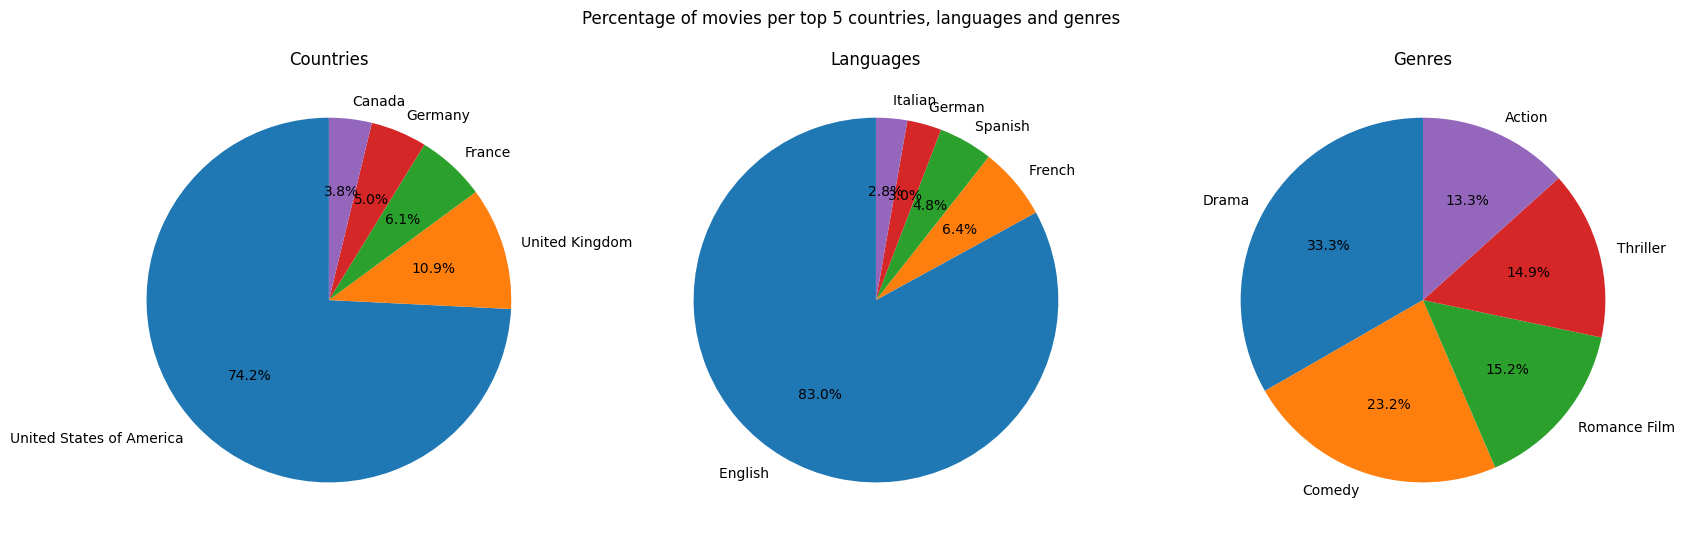

In [ ]:
#show the percentage of movies per countries, genres and languages with including only the top 5 fives categories
top5_countries = (dataFrame_movie['Country_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]
top5_languages = (dataFrame_movie['Language_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]
top5_genres = (dataFrame_movie['Genre_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]

# remove "Language" in the label because it is not useful 
labels_language = [label.replace('Language', '') for label in top5_languages.index]

#plot the pie charts
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Percentage of movies per top 5 countries, languages and genres')
axes[0].pie(top5_countries, labels=top5_countries.index, autopct='%1.1f%%', shadow=False, startangle=90)
axes[0].set_title('Countries')
axes[1].pie(top5_languages, labels=labels_language, autopct='%1.1f%%', shadow=False, startangle=90)
axes[1].set_title('Languages')
axes[2].pie(top5_genres, labels=top5_genres.index, autopct='%1.1f%%', shadow=False, startangle=90)
axes[2].set_title('Genres')
plt.show()

The United States stands at the forefront of the movies featured in our dataset, representing the majority of the film entries. This underscores our intentional focus on analyses centered around Hollywood. Consequently, we can narrow down our selection of actors to those renowned in the Hollywood sphere. This observation is further reinforced when considering the language of the movies. With nearly three-quarters of them in English, catering to an English-speaking audience, the revenues of each movie can be meaningfully compared. Notably, the prevalent genre in our dataset is Drama. While this fact does not pose an a priori impact on our analysis, it is an interesting observation.

<a id="7"></a> 
### 3.2. Histogram of Revenues

### Important note about revenues :
As we said previously, one dollar today doesn't worth one dollar. This is what we called the time value of money. After having performed this analysis with the actual revenues earned by the movie maker at their publication (we called that "Revenues"). We will reconduct these analysis with taking into account the time value of money. We will refer the money with the "inflation" effect with the "adj. Revenues" that stands for "adjusted revenues". The reference year is 2010, this means that 1$ in 2010 is 1$ in the dataset and every 1$ in another year is calculated to reflect the worth of 2010.

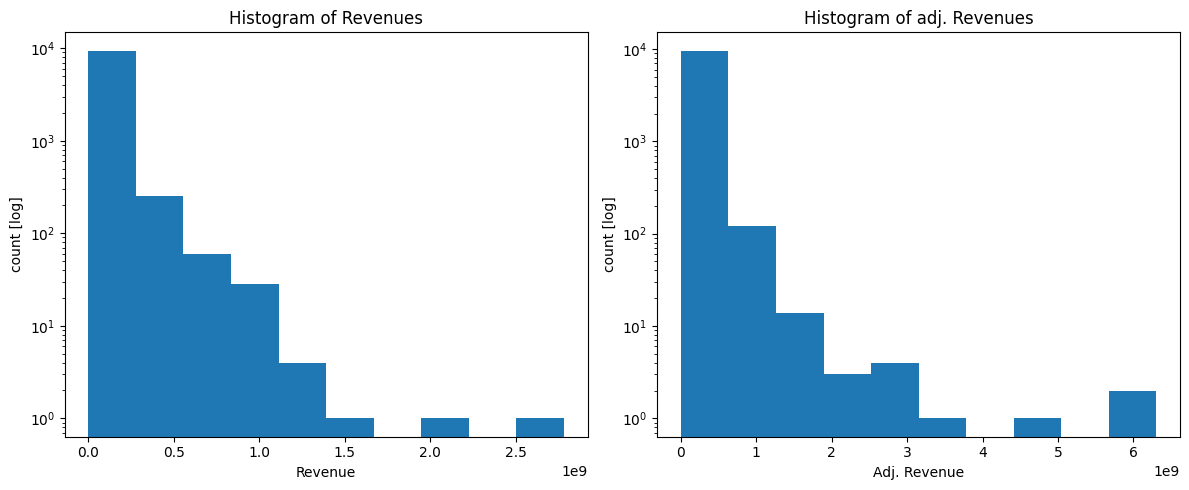

In [ ]:
# I want to show both figures next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution of Revenues
dataFrame_movie['Revenue'].plot(kind='hist', logy=True, ax=axes[0])
axes[0].set_xlabel('Revenue')
axes[0].set_ylabel('count [log]')
axes[0].set_title('Histogram of Revenues')

# Distribution of adj Revenues
dataFrame_movie['adj Revenue'].plot(kind='hist', logy=True, ax=axes[1])
axes[1].set_xlabel('Adj. Revenue')
axes[1].set_ylabel('count [log]')
axes[1].set_title('Histogram of adj. Revenues')

plt.tight_layout()

# Show the plots
plt.show()

The shape of the two histograms are more or less similar. The adj. revenues are shifted to the right of the x-axis. This behaviour was predicted because the majority of movies have been published before 2010, therefore revenues earned have been inflated. 

In [ ]:
dataFrame_movie['Revenue'].describe()

count    9.734000e+03
mean     4.595233e+07
std      1.116413e+08
min      1.000000e+00
25%      1.793176e+06
50%      9.325774e+06
75%      3.708404e+07
max      2.782275e+09
Name: Revenue, dtype: float64

In [ ]:
dataFrame_movie['adj Revenue'].describe()


count    9.734000e+03
mean     7.063208e+07
std      1.875572e+08
min      1.309072e+00
25%      4.417192e+06
50%      1.865042e+07
75%      6.238308e+07
max      6.303030e+09
Name: adj Revenue, dtype: float64

We can see that the mean of the revenue is around 46 million USD. The frequency decrease with the magnitude of revenues. We also observe some outliers, the maximum (higher than 2 billions) are outliers in our dataset. Revenues near 0 \$ can be problem in the data but they also can be film that really underperformed. They are kept in the analysis. Please recall that we already removed 0 \$ revenues. 

We can see that the mean of the revenue is around 70 million USD. The frequency decrease with the magnitude of revenues. We also observe some outliers, the maximum (higher than 6 billions) are outliers in our dataset. 

<a id="8"></a> 
### 3.3. Evolution of mean Revenue per year

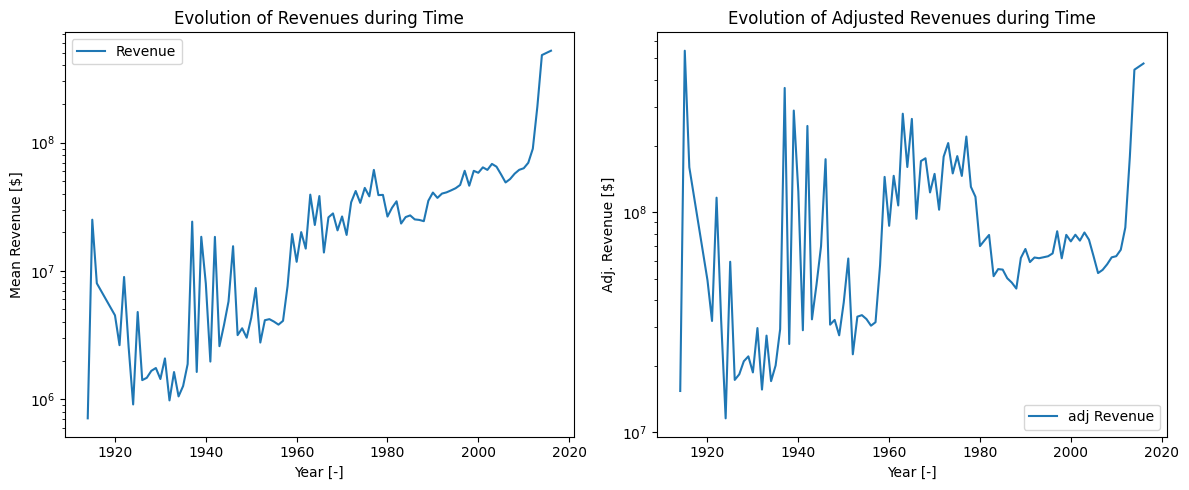

In [ ]:
# I want to plot the figures next to each others
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Evolution of Revenues over year
df_revenue = dataFrame_movie[['Year', 'Revenue']].groupby(['Year']).mean()
df_revenue['std'] = dataFrame_movie[['Year', 'Revenue']].groupby(['Year']).std()
df_revenue['Year'] = df_revenue.index
df_revenue = df_revenue[df_revenue['Year'] > 1900]

df_revenue.plot(x='Year', y='Revenue', logy=True, ax=axes[0])
axes[0].set_xlabel('Year [-]')
axes[0].set_ylabel('Mean Revenue [$]')
axes[0].set_title('Evolution of Revenues during Time')

# Evolution of Adj Revenues over year
df_adj_revenue = dataFrame_movie[['Year', 'adj Revenue']].groupby(['Year']).mean()
df_adj_revenue['std'] = dataFrame_movie[['Year', 'adj Revenue']].groupby(['Year']).std()
df_adj_revenue['Year'] = df_adj_revenue.index
df_adj_revenue = df_adj_revenue[df_adj_revenue['Year'] > 1900]

df_adj_revenue.plot(x='Year', y='adj Revenue', logy=True, ax=axes[1])
axes[1].set_xlabel('Year [-]')
axes[1].set_ylabel('Adj. Revenue [$]')
axes[1].set_title('Evolution of Adjusted Revenues during Time')

plt.tight_layout()

# Show the plots
plt.show()



We can see that the log revenues seem to have an increasing trend from 1900 to 2023, especially in recent years, we can explain that by inflation. This is why we will take the consumer price index (CPI) as a measure of inflation to make revenues comparable over time.

We increase drastically the volatility of the money earned when we take the adj. revenues but we remove the increasing trend (which was the goal)

<a id="9"></a> 
### 3.4. Histogram of Average Rating

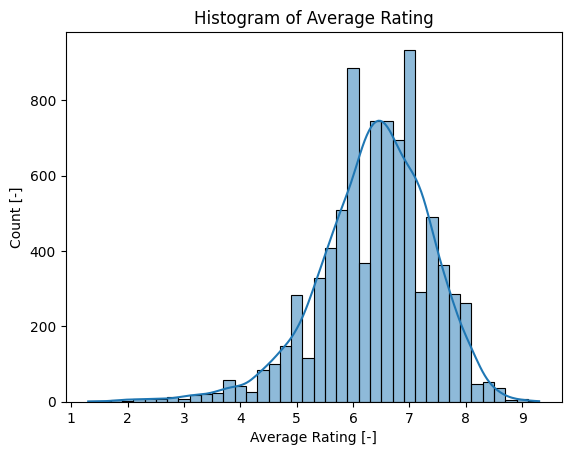

In [ ]:
# Distribution of Average Ratings
sns.histplot(data=dataFrame_movie, x='averageRating', bins=40, kde = True)
plt.title('Histogram of Average Rating')
plt.xlabel('Average Rating [-]')
plt.ylabel('Count [-]')
plt.show()


In [ ]:
#Descriptive data for the Average Rating
dataFrame_movie['averageRating'].describe()

count    8426.000000
mean        6.378293
std         0.992606
min         1.300000
25%         5.800000
50%         6.500000
75%         7.100000
max         9.300000
Name: averageRating, dtype: float64

We can see that the mean of the average rating is around 6.3 out of 10. Most of the ratings appears between 5.8 and 7.1. Not surprinsingly, no movie is rated with the maximal or the minimal rate since we are taking an average rating. 

<a id="10"></a> 
### 3.5. Evolution of the mean Average Rating per year

In [ ]:
# Evolution of ratings during time 
df2 = dataFrame_movie[['Year','averageRating']].groupby(['Year']).mean()
df2['std'] = dataFrame_movie[['Year','averageRating']].groupby(['Year']).std()
df2['Year']=df2.index
df2 = df2[df2['Year'] > 1900]

Text(0, 0.5, 'Average Rating [-]')

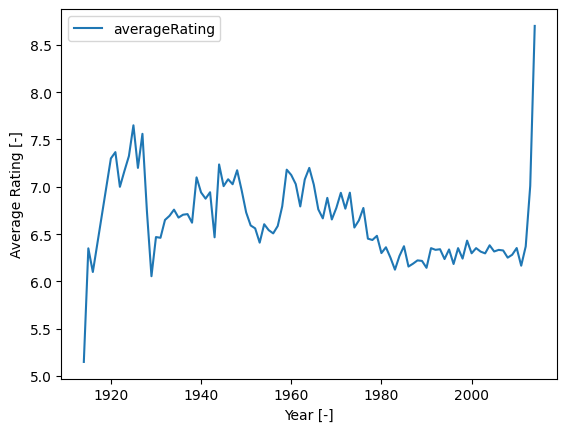

In [ ]:
# plot of the Evolution of average rating
df2.plot(x = 'Year', y='averageRating')
plt.xlabel('Year [-]')
plt.ylabel('Average Rating [-]')

We can see that average ratings seem to be lower by one point for the second part of the 20th century, however, they have increased again in the last years. 

<a id="11"></a> 
### 3.6. Scatter plot of the average Rating and Revenue

Text(37.722222222222214, 0.5, 'Revenue [-]')

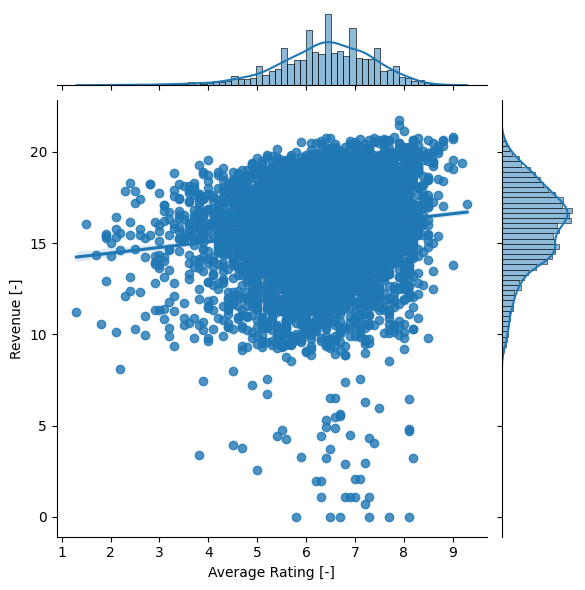

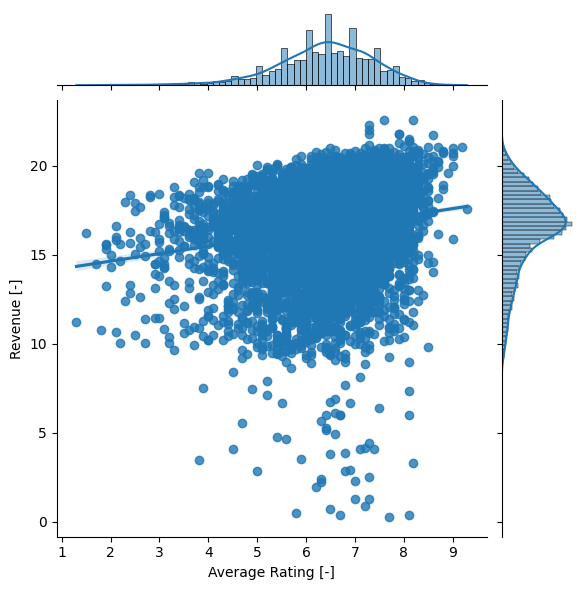

In [ ]:
#scatter plot between the average Rating and the Revenue 
sns.jointplot(x=dataFrame_movie['averageRating'], y= np.log(dataFrame_movie['Revenue']), kind="reg")
plt.xlabel('Average Rating [-]')
plt.ylabel('Revenue [-]')

#scatter plot between the average Rating and the Revenue 
sns.jointplot(x=dataFrame_movie['averageRating'], y= np.log(dataFrame_movie['adj Revenue']), kind="reg")
plt.xlabel('Average Rating [-]')
plt.ylabel('Revenue [-]')

It is hard from the plot to see whether the two variables are correlated. So we try to compute the Pearson correlation.  

We try to compute it between the average rating and revenues. We compute also the correlation grouping by multiple variables such as the year, the language, and the countries. 
 
We obtain that the first have significant negative correlation, when we group by year. When we group by year, we surprisingly an negative correlation between revenu and rating. 
We obtain a significant negative correlation at 5% level when we group by country. 

<a id="12"></a> 
### 3.7. Pearson correlation

In [ ]:
# Pearson correlation when we group by year
df2['Revenue']= dataFrame_movie[['Year','Revenue']].groupby(['Year']).mean()['Revenue']
df2['Revenue'] = np.log(df2['Revenue'])
df2.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df2 = df2.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df2['averageRating'],df2['Revenue'])  

PearsonRResult(statistic=-0.3111719327099236, pvalue=0.0022677292561546665)

In [ ]:
# Pearson correlation when we group by Country
copy_data = dataFrame_movie.copy(deep=True)
copy_data['Country_List'] = copy_data['Country_List'].apply(tuple)
copy_data['Revenue'] = np.log(copy_data['Revenue'])
df3 = copy_data[['Revenue','Country_List']].groupby(['Country_List']).mean()
df3['averageRating']= copy_data[['averageRating','Country_List']].groupby(['Country_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue'])  

PearsonRResult(statistic=-0.08575924199041147, pvalue=0.048674731216506874)

In [ ]:
# Pearson correlation when we group by Language
copy_data['Language_List'] = copy_data['Language_List'].apply(tuple)
df3 = copy_data[['Revenue','Language_List']].groupby(['Language_List']).mean()
df3['averageRating']= copy_data[['averageRating','Language_List']].groupby(['Language_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue']) 

PearsonRResult(statistic=-0.027175010191771105, pvalue=0.5050252050852481)

We perform the same correlation with the adj. revenue to see if we notice a difference.

In [ ]:
# Pearson correlation when we group by year
df2['adj Revenue']= dataFrame_movie[['Year','adj Revenue']].groupby(['Year']).mean()['adj Revenue']
df2['adj Revenue'] = np.log(df2['adj Revenue'])
df2.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df2 = df2.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df2['averageRating'],df2['adj Revenue'])  

PearsonRResult(statistic=0.1068559901874457, pvalue=0.3053235578055561)

In [ ]:
# Pearson correlation when we group by Country
copy_data = dataFrame_movie.copy(deep=True)
copy_data['Country_List'] = copy_data['Country_List'].apply(tuple)
copy_data['adj Revenue'] = np.log(copy_data['adj Revenue'])
df3 = copy_data[['adj Revenue','Country_List']].groupby(['Country_List']).mean()
df3['averageRating']= copy_data[['averageRating','Country_List']].groupby(['Country_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['adj Revenue'])  

PearsonRResult(statistic=-0.06632153457012958, pvalue=0.1276425068923224)

In [ ]:
# Pearson correlation when we group by Language
copy_data['Language_List'] = copy_data['Language_List'].apply(tuple)
df3 = copy_data[['adj Revenue','Language_List']].groupby(['Language_List']).mean()
df3['averageRating']= copy_data[['averageRating','Language_List']].groupby(['Language_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['adj Revenue']) 

PearsonRResult(statistic=0.03097642994373994, pvalue=0.44731745073741086)

When we try to see the correlation between average rating and adjusted revenue, the significance that we observed previously disappears, which is more intuitive.

<a id="13"></a> 
### 3.8 Box plot of the number of known actor versus the log revenues 

In [ ]:
#extract Freebase ID, Name, Revenue, averageRating, numVotes, List of actors to a new DataFrame
dataFrame_reg = dataFrame_movie[['Freebase ID', 'Name', 'Revenue', 'averageRating', 'numVotes', 'List of known actors', 'Number of known actors', 'adj Revenue']]

dataFrame_reg.rename(columns={"Freebase ID": "id", "Name" : "movie","Revenue":"revenue","averageRating":"rating", \
                                        "List of known actors":"actors","Number of known actors":"numbKnownActors"},inplace=True)

print(dataFrame_reg.shape)

(9734, 8)


In [ ]:
#let's create a new feature names "log_revenue" that is the log of the revenue
dataFrame_reg['log_revenue']=dataFrame_reg.revenue.apply(lambda x : np.log(x))
dataFrame_reg['log_adj_revenue']=dataFrame_reg['adj Revenue'].apply(lambda x : np.log(x))


#remove the movies with no known actors
dataFrame_reg=dataFrame_reg[dataFrame_reg["numbKnownActors"]>0]
print(dataFrame_reg.shape)

#apply following function to make the boxplot more readable
dataFrame_reg['numberOfKnownActors']=dataFrame_reg.numbKnownActors.apply(lambda x : transformCat(x))


(9492, 10)


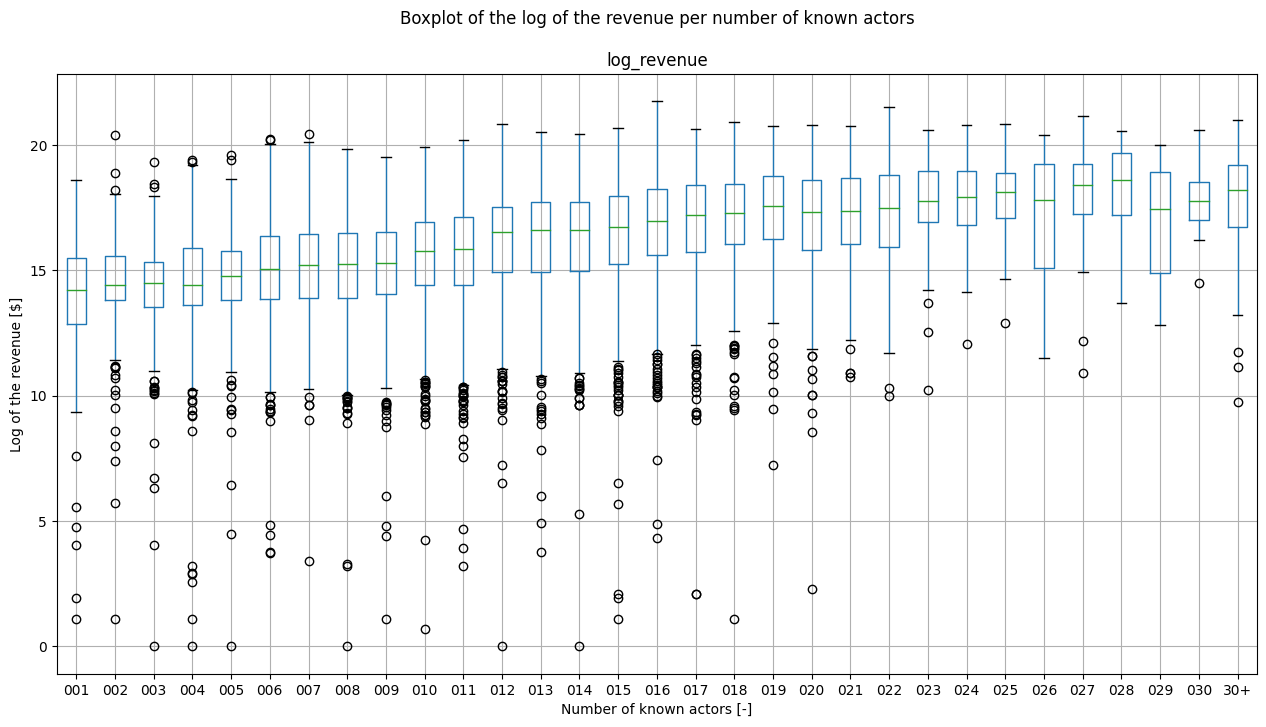

In [ ]:
#plot a boxplot of the log of the revenue per number of known actors
ax = dataFrame_reg.boxplot(column=['log_revenue'], by=['numberOfKnownActors'],figsize=(15, 8))
plt.suptitle('Boxplot of the log of the revenue per number of known actors')
plt.xlabel('Number of known actors [-]')
plt.ylabel('Log of the revenue [$]')
plt.show()


We can see a positive trends meaning that higher revenues are linked with more known actors in a movie. Outliers seem to reduce when we increase the number of actor per movie. The whiskers are globally constant along this analysis.  

### 3.8.1 Box plot of the number of known actor versus the log adj. revenues 

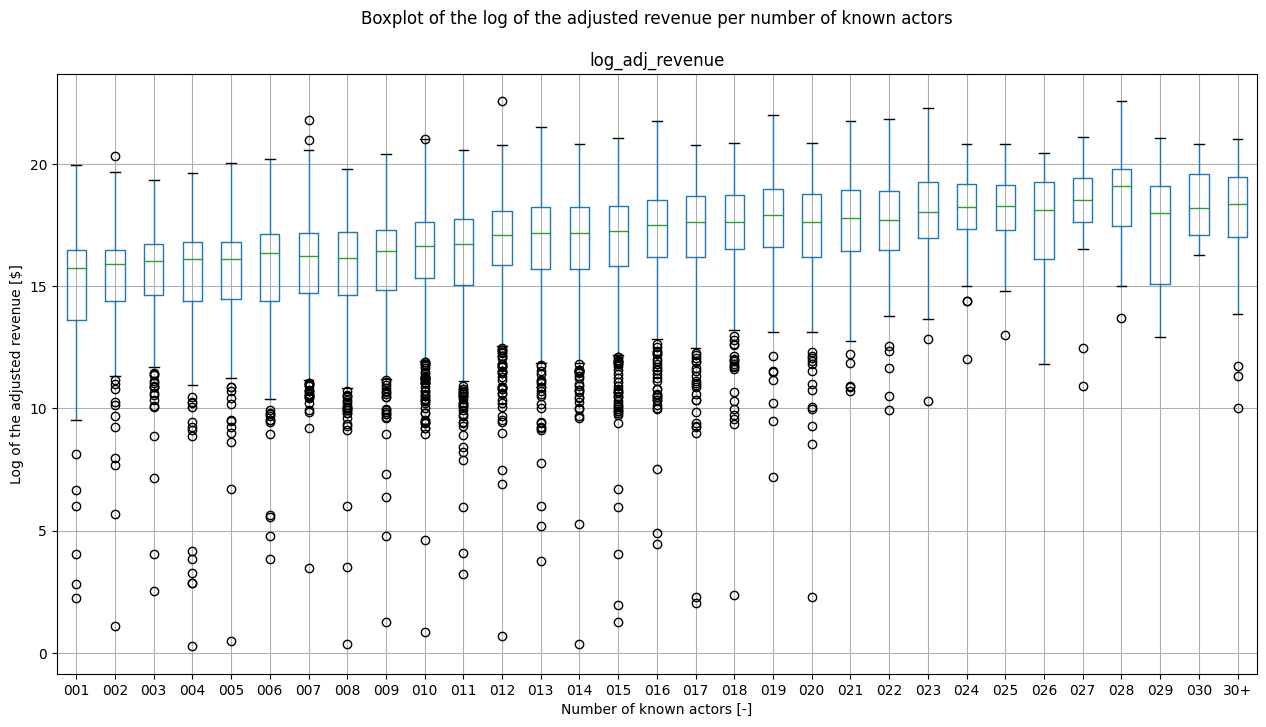

In [ ]:
#plot a boxplot of the log of the revenue per number of known actors
ax = dataFrame_reg.boxplot(column=['log_adj_revenue'], by=['numberOfKnownActors'],figsize=(15, 8))
plt.suptitle('Boxplot of the log of the adjusted revenue per number of known actors')
plt.xlabel('Number of known actors [-]')
plt.ylabel('Log of the adjusted revenue [$]')
plt.show()

We cannot observe any significant difference between the two figures. Both trends look identical, the whiskers are still more or less constant. The only difference stands in the height of the values. They are higher for logarithm of adjusted revenues. 

<a id="14"></a> 
### 3.9. Linear Regression - log (adj.) revenue on number of known actors

In [ ]:
for k in range(1,31):
    dataFrame_reg['n'+str(k)]=(dataFrame_reg.numbKnownActors == k)*1
dataFrame_reg['n31+']=(dataFrame_reg.numbKnownActors >= 31)*1

X_name = ['n'+str(x) for x in range(2,31)]
X_name+=['n31+']

In [ ]:
X = dataFrame_reg[X_name].values
y = dataFrame_reg.log_revenue.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     53.18
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          4.01e-292
Time:                        11:00:50   Log-Likelihood:                -21196.
No. Observations:                9492   AIC:                         4.245e+04
Df Residuals:                    9461   BIC:                         4.268e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9396      0.178     78.473      0.0

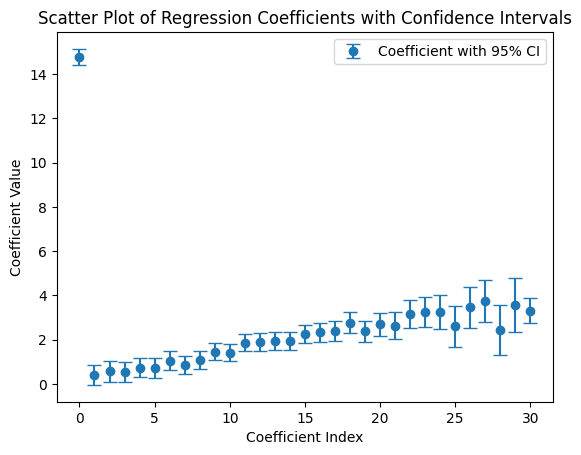

In [ ]:
# Extract the coefficients and confidence intervals
coefficients = est2.params
conf_intervals = est2.conf_int()

# Plot the coefficients with error bars representing confidence intervals
plt.errorbar(range(len(coefficients)), coefficients, yerr=np.abs(coefficients - conf_intervals.T),
             fmt='o', capsize=5, label='Coefficient with 95% CI')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Scatter Plot of Regression Coefficients with Confidence Intervals')
plt.legend()
plt.show()

We can see that the probability of the F-statistic is highly close to 0 meaning that the set of independant variables (which are number of actor per movie dummies) are a significant impact on the logarithm of the revenue.

We can see that the R-squared is 0.144, which is intresting result knowing the fact that we used only dummies that enclosed similar information.

Most of the coefficient are independently significant as well. It seems that adding more known actors leads to higher revenue as we can see with the increase of the beta coefficient.

In [ ]:
y = dataFrame_reg.log_adj_revenue.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     30.98
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          2.10e-167
Time:                        11:01:14   Log-Likelihood:                -21463.
No. Observations:                9492   AIC:                         4.299e+04
Df Residuals:                    9461   BIC:                         4.321e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7786      0.183     80.895      0.0

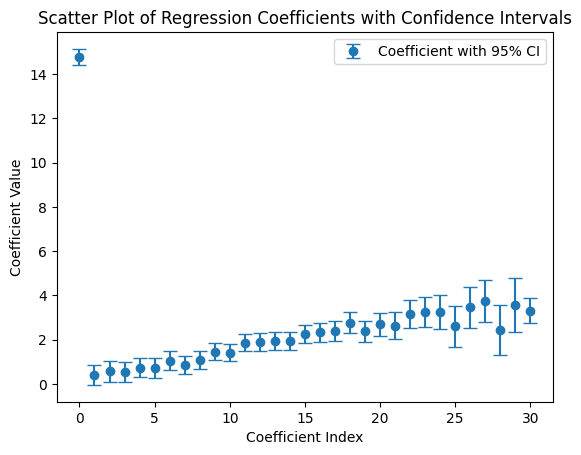

In [ ]:
# Extract the coefficients and confidence intervals
coefficients = est2.params
conf_intervals = est2.conf_int()

# Plot the coefficients with error bars representing confidence intervals
plt.errorbar(range(len(coefficients)), coefficients, yerr=np.abs(coefficients - conf_intervals.T),
             fmt='o', capsize=5, label='Coefficient with 95% CI')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Scatter Plot of Regression Coefficients with Confidence Intervals')
plt.legend()
plt.show()

The exact same conclusion as before can be conclude for this analysis.

<a id="15"></a> 
### 3.10. Box plot of the rating per number of known actors

In [ ]:
dataFrame_reg2=dataFrame_reg.dropna(subset=["rating"])

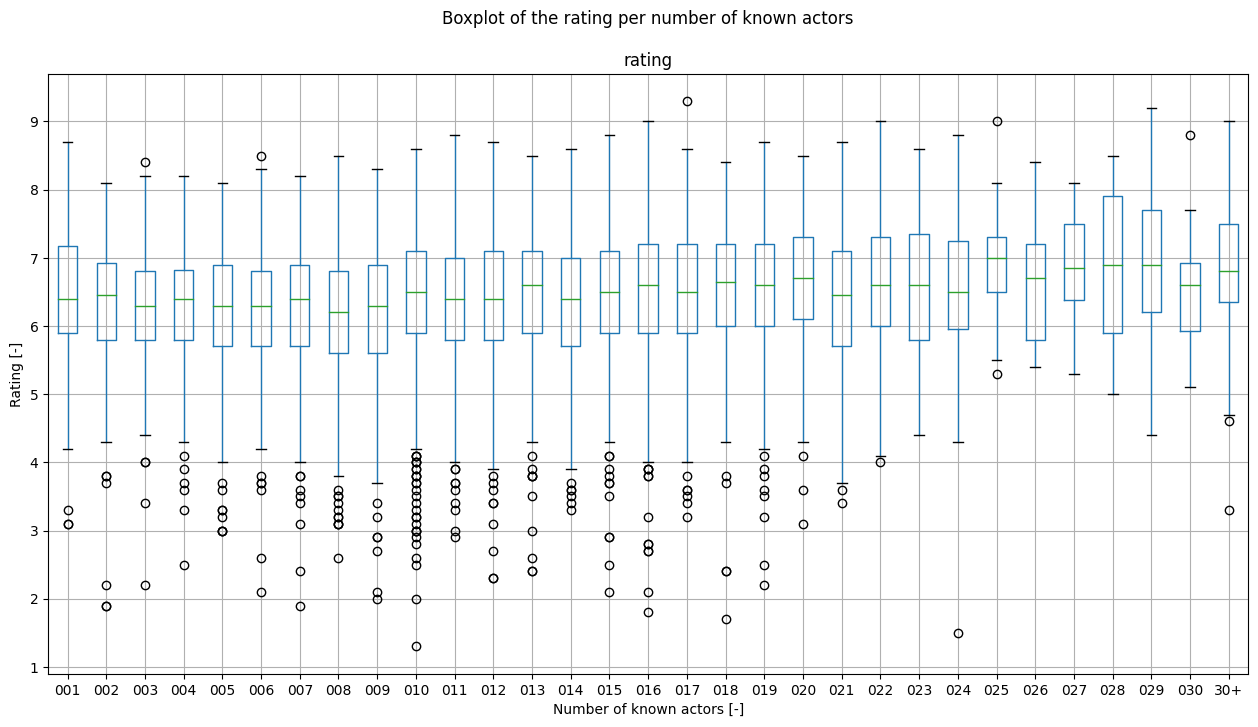

In [ ]:
dataFrame_reg2.boxplot(column=['rating'], by=['numberOfKnownActors'],figsize=(15, 8))
plt.suptitle('Boxplot of the rating per number of known actors')
plt.xlabel('Number of known actors [-]')
plt.ylabel('Rating [-]')
plt.show()

We cannot see any clear trend. In the same way, outliers seem to reduce when we increase the number of actor per movie and the whiskers are globally constant along this analysis.  

<a id="16"></a> 
### 3.11. Linear regression - Rating on number of actors

In [ ]:
X = dataFrame_reg2[X_name].values
y = dataFrame_reg2.rating.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.323
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           2.09e-19
Time:                        10:12:10   Log-Likelihood:                -11632.
No. Observations:                8311   AIC:                         2.333e+04
Df Residuals:                    8280   BIC:                         2.354e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4451      0.097     66.241      0.0

We can see that the probability of the F-statistic (9.86e-18) which is still close to 0 meaning that the set of independant variables (which are number of actor per movie dummies) are a significant impact on the ratings.

We can see that the R-squared is 0.016, which is less intresting. The number of known actors has a lower impact on the rating.

However, most of the coefficient are not independently significant. It seems that adding more known actors leads to higher revenue as we can see with the increase of the beta coefficient.

## Does an ensemble of renowned actors significantly influence a movie's revenue and critical acclaim?

Excluding the salary of renowned actors who play in the movie, the analysis showed that an ensemble of renowned actors significantly influences a movie's revenue. Please note our definition of 'renowned' actors—they are actors known enough to be included in the dataset.

An ensemble of renowned actors doesn't have a significant influence on the movie's rating. 

Our theory about these results is the following: The cast of a movie is a good audience attractor. This influences the decision to go to the movie theater to watch the movie with the plethora of known actors. This increases the revenue of the movie maker but doesn't impact the intrinsic quality of the movie. Perhaps viewers who come to the movie theater have preconceived notions about the movie due to the great cast. This attitude will impact the feelings of the spectator towards the movie and, therefore, influence its rating.

<a id="18"></a> 
## 5. Network Analysis

In [ ]:
#keep only 40 actors with the most of interactions
list_actor_to_remove=list(pure_interaction.sort_values(ascending=False).index)[40:]

#drop the actors from the binary matrix
new_filtered_binary_matrix=filtered_binary_matrix.drop(list_actor_to_remove,axis=1)

In [ ]:
binary_matrix_column = new_filtered_binary_matrix.columns


matrix = np.zeros([len(binary_matrix_column),len(binary_matrix_column)])

i = 0
j = 0
# Iteration in every row and column to calculate the interaction
for col in binary_matrix_column:
    result = []
    j = 0
    for col2 in binary_matrix_column:
        #since the column are dummies, we can just multiply
        matrix[i,j]= (filtered_binary_matrix[col]* filtered_binary_matrix[col2]).sum()
        j+= 1
    i+=1

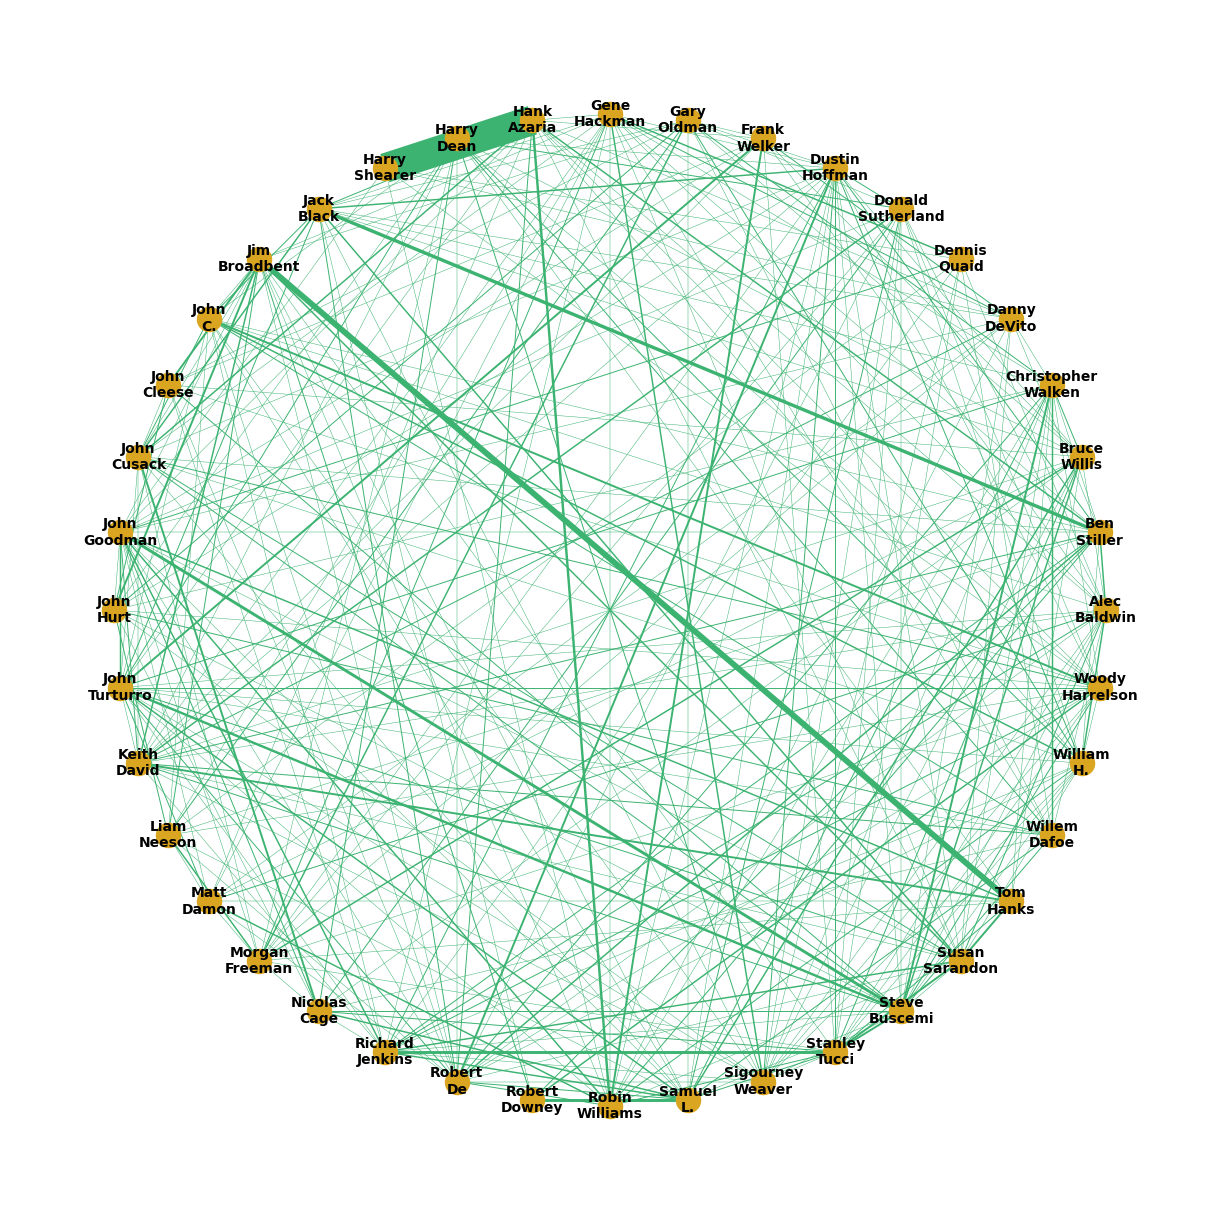

In [ ]:
actors=new_filtered_binary_matrix.columns
movie_matrix=matrix


#create the graph
G = nx.Graph()

#add nodes to it
G.add_nodes_from(actors)

# Add edges to the graph with weights from the matrix
for i in range(len(actors)):
    for j in range(i + 1, len(actors)):
        weight = movie_matrix[i][j]
        if weight > 0:
            G.add_edge(actors[i], actors[j], weight=weight)


plt.figure(figsize=(12, 12))

#use a circular layout
pos = nx.circular_layout(G)

#calculate edge widths based on the logarithm of the number of movies
edge_widths = [0.35*weight for actor1, actor2, weight in G.edges(data='weight')]

#draw the graph with variable edge widths and green edges
nx.draw(G, pos, with_labels=False, node_size=300, node_color='goldenrod', font_size=8, width=edge_widths, edge_color='mediumseagreen')

#draw node labels with line breaks
node_labels = {actor: f"{actor.split()[0]}\n{actor.split()[1]}" for actor in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_weight='bold', font_color='black', font_size=10)

plt.show()

Each node represents an actor. The width of the edge between two nodes is proportional to the number of movies the two actors (two nodes) played togheter. To construct this graph, we restrict ourselves to actors with most interaction wth other actors through movies. We plan to use the same restrictions to make assessment about the contribution/interaction to revenue of the movie. Finally, we plan to modify the network plot in order to make it more readable. 